## 1. 필요한 패키지 로드

In [103]:
# Viola-Jones algorithm stencil code 
# Written by Soochahn Lee for Computer Vision @ Kookmin University

import csv
import sys
import argparse
import numpy as np
import scipy.io as scio

import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io, filters, feature, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray

import student as student
np.random.seed(0)

### size of haar_like_feature ###
hlf_sz = (18,18)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. 실험용 데이터 파일 로딩 함수 정의

실험용 영상 DB를 읽어오고, 영상 사이즈, 컬러/흑백, 픽셀 값 범위 ([0-255]->[0.0 1.0]) 등 포맷을 적절하게 조정하는 함수를 구현하시오. (해당 함수 자유롭게 외부 자료 참고하여 작성하여 됨을

In [27]:
# load positve and negative dataset
DATA_NUM = 1000
# positive data: size n_p x h x w, where n_p = number of positive images and h_i, w_i are width and height of images
data_pos = student.load_folder_imgs('../data/pos', hlf_sz)[:DATA_NUM,:,:]
# negative data: size n_n x h x w, where n_n = number of negative images and h_i, w_i are width and height of images
data_neg = student.load_folder_imgs('../data/neg', hlf_sz)[:DATA_NUM,:,:]

# concatenate all images
n_p = data_pos.shape[0]
n_n = data_neg.shape[0]
data = np.row_stack([data_pos, data_neg])
# create ndarray to store positive/negative labels
labels = np.row_stack([np.ones([n_p,1]), np.zeros([n_n,1])])
weights = np.row_stack([np.ones([n_p,1]), np.ones([n_n,1])]).astype(np.float32)

## 3. Integral Image 함수 선언 및 계산

아래 함수 호출을 통해 integral image들이 계산되도록 student.py 파일에 있는 get_integral_images(data) 함수를 구현하시오.

In [28]:
iimgs = student.get_integral_imgaes(data)

In [29]:
print(data[0,1:3,1:4].sum())
print(iimgs[0,2,3] - iimgs[0,0,3] - iimgs[0,2,0] + iimgs[0,0,0])

print(data[0,5:9,10:15].sum())
print(iimgs[0,8,14] - iimgs[0,4,14] - iimgs[0,8,9] + iimgs[0,4,9])

0.013184151439411183
0.013184151439411183
0.05969086335263495
0.05969086335263492


## 4. Haar-like feature 계산 함수 

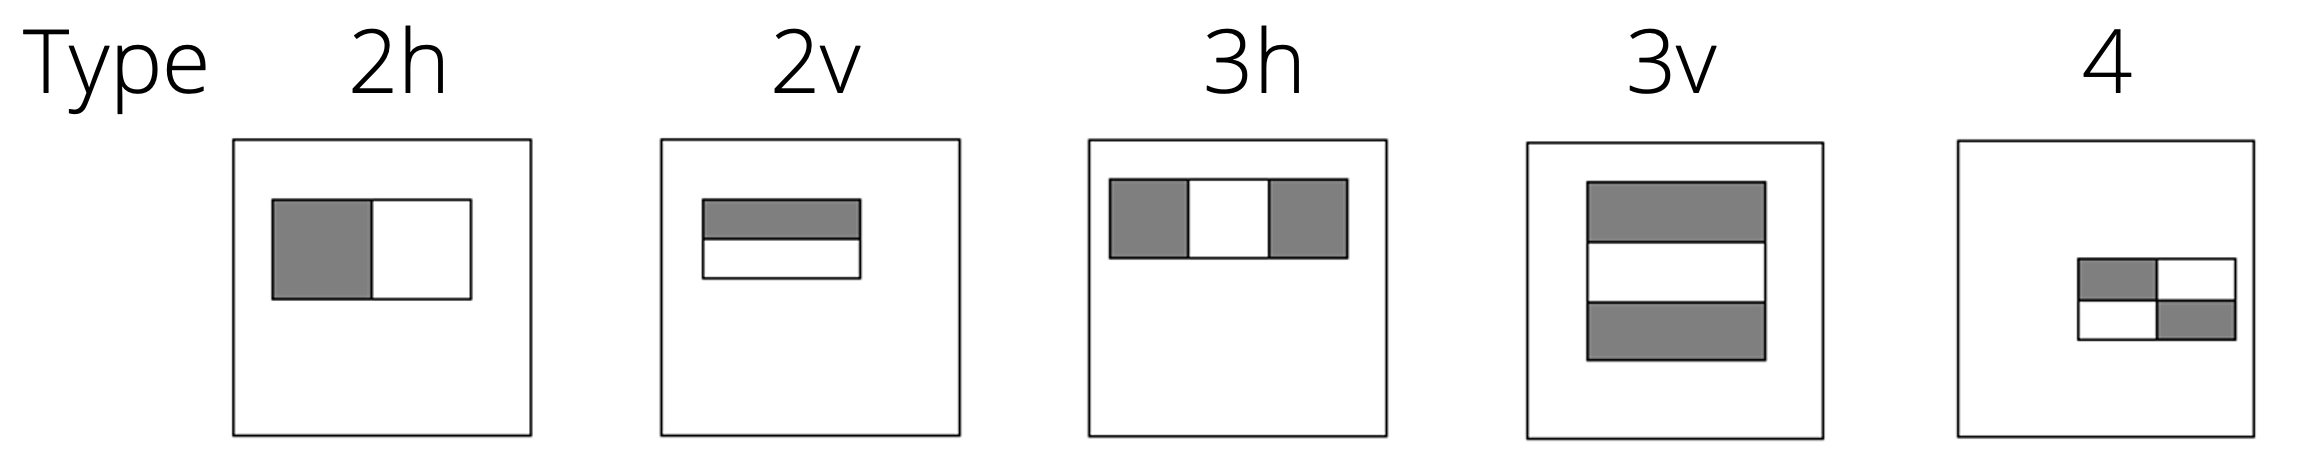

1. 위 그림과 같이 5종류의 Haar-like feature 형태를 적용하고, 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (n_feat x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
   이때 각 feature마다 모든 사각 영역의 크기는 정수 값을 가지며, feature 종류마다 음/양 분할된 사각 영역은 반드시 동일한 크기를 갖도록 하시오.

2. 각 feature 종류별로 주어진 image dataset의 shape (n_image x w_i x h_i) ndarray 및 feature 위치/크기의 shape (n_feat x 4) ndarray에 대해 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.

In [30]:
LOAD_SAVE_DATA = False

# 1. 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (개수 x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
feat2h_ps = student.get_feature_pos_sz_2h(hlf_sz)
feat2v_ps = student.get_feature_pos_sz_2v(hlf_sz)
feat3h_ps = student.get_feature_pos_sz_3h(hlf_sz)
feat3v_ps = student.get_feature_pos_sz_3v(hlf_sz)
feat4_ps = student.get_feature_pos_sz_4(hlf_sz)

if not LOAD_SAVE_DATA:
    # 2. 각 feature 종류별로 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.
    feat2h = student.compute_features_2h(feat2h_ps ,iimgs)
    feat2v = student.compute_features_2v(feat2v_ps ,iimgs)
    feat3h = student.compute_features_3h(feat3h_ps ,iimgs)
    feat3v = student.compute_features_3v(feat3v_ps ,iimgs)
    feat4 = student.compute_features_4(feat4_ps ,iimgs)

    # concatenate computed features
    feat = np.column_stack(([feat2h, feat2v, feat3h, feat3v, feat4]))
    np.save("feat.npy",feat)
else:
    feat = np.load("feat.npy")
num_feat_per_type = [feat2h_ps.shape[0], feat2v_ps.shape[0], feat3h_ps.shape[0], feat3v_ps.shape[0], feat4_ps.shape[0]]
feat_ps = np.row_stack([feat2h_ps, feat2v_ps, feat3h_ps, feat3v_ps, feat4_ps])
feat_labels = []
for i in range(len(num_feat_per_type)):
    feat_labels += [i] * num_feat_per_type[i]
feat_labels = np.array(feat_labels)

print(feat_ps.shape)

(21196, 4)


## 5. 각 feature 별 threshold 및 sign 도출하여 weak classifier 생성 후 에러 계산

개별 영상 $I$에 대한 feature 값 $f(I)$이 임계값 $\theta$을 초과하는지 아닌지에 따라 얼굴인지 아닌지를 판별하게 된다. 이때 $f(I)$의 특성에 따라 $\theta$을 초과하는 경우가 배경이 될 수도 있으므로, 부호(극성) p 값도 +1/-1 중에 적절한 값을 가진다.

$$
h(I, f, p, \theta) = \begin{cases} 
    1 & \text{if }  p~f(I) < p~\theta \\  
    0 & \text{otherwise}
\end{cases}
$$

위에서 계산된 feat 행렬의 열에는 전체 영상의 개별 feature 계산 값이 저장되어 있는데, 이를 이용하여 각 feature 별로 아래 식에 따라 positive & negative 영상을 구분하는 임계값과 부호를 도출해 주는 함수를 작성하시오. 

참고: 임계값과 부호를 도출할 때에는 계산된 feature 값들을 정렬하고, 정렬된 feature 값들을 순서대로 확인하면서, 해당 feature 값을 초과/미만(부호에 따라)하는 feature 값을 갖는 positive/negative 영상들의 개수(weight)들의 총합을 고려하여 정하시오. 그리고 도출된 임계값 $\theta$와 부호 $p$을 통해 feature 별로 weak classifier가 완성되므로, 각 weak classifier 별 판별 오류를 계산하도록 하시오.

In [31]:
thetas, signs, errors = student.get_weak_classifiers(feat, labels, weights)

100%|██████████| 1999/1999 [05:42<00:00,  5.83it/s]


In [105]:
# 위에서 산출된 error 배열을 통해 최적의 weak classifier를 도출하고,
# 해당 weak classifier의 haar-like feature를 영상 위에 겹쳐서 표기하는 함수 student.overlay_haar_feature를 구현하시오.
best_acc = 0
best_i = 0
for i in tqdm(range(data.shape[0])):
    datalen = i + 1
    sorted_error_index = np.argsort(errors)
    sorted_error_index = sorted_error_index[:datalen]

    target_feat = feat[:,sorted_error_index]
    target_thetas = thetas[sorted_error_index]
    target_sign = signs[sorted_error_index]

    target_predict = target_feat > target_thetas.reshape(1,-1)
    target_predict = np.abs(target_predict - 1.*(target_sign==-1).reshape(1,-1))
    target_predict = np.sum(target_predict, axis=1)/target_predict.shape[1]
    target_predict = target_predict > 0.5
    target_grading = target_predict == labels.reshape(1,-1)
    acc = target_grading.sum()/target_grading.shape[1]
    if acc > best_acc:
        best_acc = acc
        best_datalen = datalen


print(best_acc)
print(best_datalen)

100%|██████████| 2000/2000 [00:28<00:00, 69.69it/s]

0.9555
1970


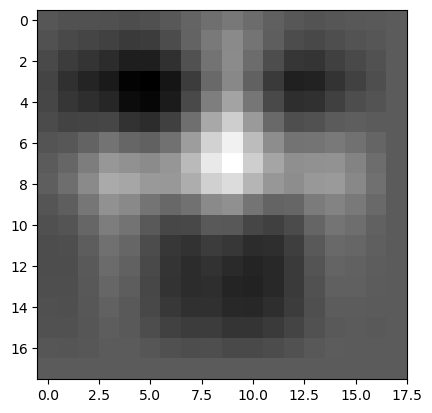

In [108]:
best_datalen = 10000
val_feat = feat_ps[:best_datalen]
val_feat_label = feat_labels[:best_datalen]
val_feat_sign = signs[:best_datalen]

label_sorted_arg = np.argsort(val_feat_label)
val_feat = val_feat[label_sorted_arg]
val_feat_label = val_feat_label[label_sorted_arg]
val_feat_sign = val_feat_sign[label_sorted_arg]

summed_feature = np.zeros(hlf_sz)
for i in range(val_feat.shape[0]):
    x,y,h,w = val_feat[i]
    t = val_feat_label[i]
    s = val_feat_sign[i]
    summed_feature += student.visualize_haar_feature(x,y,w,h,t) * s

summed_feature = summed_feature - summed_feature.min()
summed_feature = summed_feature / summed_feature.max()
plt.imshow(summed_feature, cmap='gray')


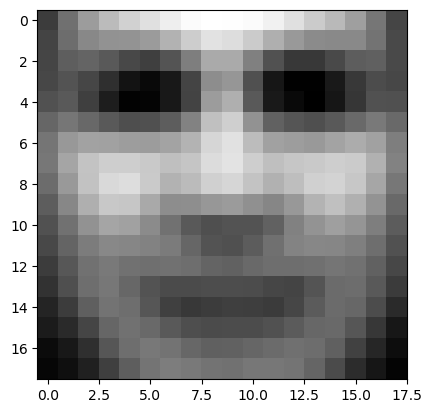

In [34]:
#data axis = 0 으로 평균
data_mean = np.mean(data, axis=0)
#visulize
plt.imshow(data_mean, cmap='gray')